<a href="https://colab.research.google.com/github/hw581/Partlll_Essay/blob/main/GD_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
##This code is for finding the training error for SGD for 10 independent experiments
##regression (squared loss), fixed design. response y is random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import numpy as np

In [121]:
#def relu(x):
    #return np.maximum(0,x)
#def drelu(x):
    #return x>=0
n=5 # number of samples
d=2 # dimension of the data
beta=1e-3
m=50 # number of neurons
num_trials = 10
num_epochs = 50
learning_rate = 0.01
optimal_loss = 0.08358031666396229
dv=1

In [122]:
X = torch.tensor([[2.0, 4.0],
                  [1.0, 2.0],
                  [2.0, 4.0],
                  [4.0, 2.0],
                  [-1, 1.0]], dtype=torch.float32)

Y = torch.tensor([1.0, -1.0, -1.0, 1.0, -1.0], dtype=torch.float32)
# Fix the random seed for reproducibility
torch.manual_seed(42)
# Generate Gaussian noise with the same shape as Y (mean=0, std=dv)
noise = dv*torch.randn_like(Y)

# Add Gaussian noise to Y
Y = Y + noise

# Create a column of ones
#ones_column = torch.ones((n, 1))

# Concatenate the ones column at the front of X
#X= torch.cat((ones_column, X), dim=1)

In [123]:
print(X)
print(Y)

tensor([[ 2.,  4.],
        [ 1.,  2.],
        [ 2.,  4.],
        [ 4.,  2.],
        [-1.,  1.]])
tensor([ 1.3367, -0.8712, -0.7655,  1.2303, -2.1229])


In [124]:
dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)


In [125]:
# 2. Define the Neural Network model with 2 layers
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)  # First layer
        self.layer2 = nn.Linear(hidden_dim, output_dim)  # Second layer

    def forward(self, x):
        x = torch.relu(self.layer1(x))  # ReLU activation function applied after the first layer
        x = self.layer2(x)  # Output layer (no activation)
        return x

In [126]:
# 3. Set dimensions
input_dim = d   # input dimension
hidden_dim = m  # Hidden layer dimension (you can tune this)
output_dim = 1  # 1D output

In [127]:
# 4. Define Mean Squared Error (MSE) loss and add weight decay (L2 regularization)
criterion = nn.MSELoss()

In [128]:
# Store losses for each trial
all_losses = []


In [129]:
#Create random dataset to evaluate accuracy
torch.manual_seed(2025)

X_test = torch.rand(50, 2) * 10 - 5 # Random 2D input in range [-5, 5)

# Set Y_test based on the condition
Y_test = torch.where(X_test[:, 0] > X_test[:, 1], torch.tensor(1.0, dtype=torch.float32), torch.tensor(-1.0, dtype=torch.float32))
# Generate Gaussian noise with the same shape as Y (mean=0, std=dv)
noise_test = dv*torch.randn_like(Y_test)
# Add Gaussian noise to Y
Y_test = Y_test + noise_test

# Create a DataLoader for the test data
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [130]:
#Define evaluation function
def evaluate_mse(model, data_loader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            predictions = model(inputs)
            loss = nn.MSELoss()(predictions, targets)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [131]:
# Track the loss values for plotting


for trial in range(num_trials):
    # 1. Generate random dataset with n samples
    #X = torch.rand(n, 2) * 5 - 5 # Random 2D input in range [-5, 5)
    # Create Y based on the first element of each row in X
    #Y = torch.where(X[:, 0] > 0, torch.tensor(1), torch.tensor(-1))
    #Y = torch.where(X[:, 0] > X[:,1], torch.tensor(1), torch.tensor(-1))
    X = X.float()
    Y = Y.float()
    # Set random seed for reproducibility
    torch.manual_seed(trial)
    np.random.seed(trial)

    # Initialize model and optimizer
    model = SimpleNN(input_dim, hidden_dim, output_dim)
    # Using SGD optimizer with weight decay
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=beta)  # weight_decay is the L2 penalty
    # Training loop
    trial_losses = []
    for epoch in range(num_epochs):
      for batch_X, batch_Y in dataloader:


        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()

        trial_losses.append(loss.item()+(beta/2)*sum(param.pow(2).sum().item() for param in model.parameters()))
        # Optionally print loss every 50 epochs
        if (epoch + 1) % 50 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()+(beta/2)*sum(param.pow(2).sum().item() for param in model.parameters()):.4f}')

    all_losses.append(trial_losses)

Epoch [50/50], Loss: 1.7870
Epoch [50/50], Loss: 1.7893


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [50/50], Loss: 1.7866
Epoch [50/50], Loss: 1.7896
Epoch [50/50], Loss: 1.7892
Epoch [50/50], Loss: 1.7887
Epoch [50/50], Loss: 1.7856
Epoch [50/50], Loss: 1.7982
Epoch [50/50], Loss: 1.7867
Epoch [50/50], Loss: 1.7879


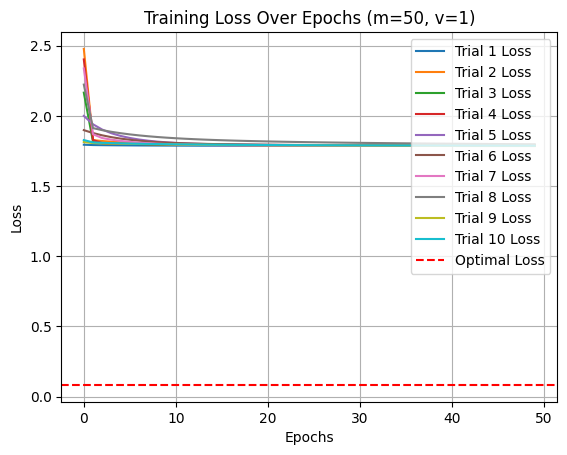

In [132]:
# 6. Plot the loss over the number of epochs
for trial in range(num_trials):
    plt.plot(range(num_epochs), all_losses[trial], label=f'Trial {trial + 1} Loss', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss Over Epochs (m={m}, v={dv})')
# Plot a horizontal line indicating the optimal value
plt.axhline(y=optimal_loss, color='r', linestyle='--', label=f'Optimal Loss')
plt.grid(True)

# Display the legend
plt.legend(loc='upper right')

# Save the plot
#plt.savefig('losses_plot.png')

plt.show()

Epoch [50/50], Test Loss: 1.731748104095459:.4f


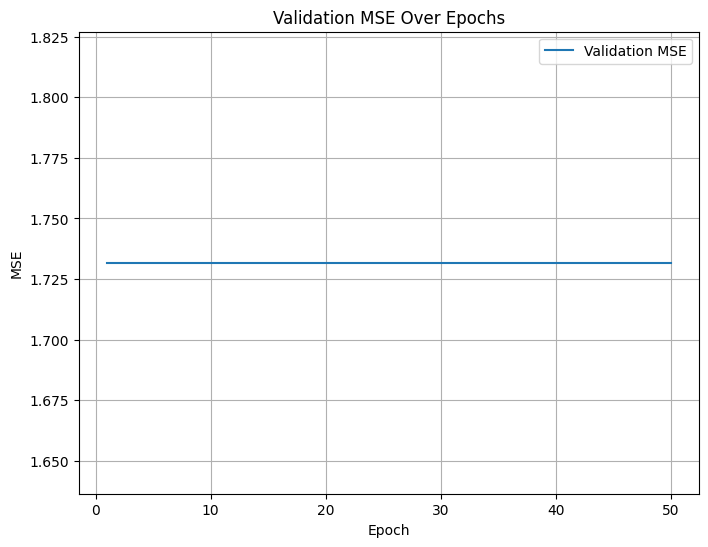

In [133]:
# Plot training and validation MSE
plt.figure(figsize=(8, 6))

# Store test losses for each epoch
test_losses = []

for epoch in range(num_epochs):
    # Evaluate the model on the random test data at the end of each epoch
    test_loss = evaluate_mse(model, test_loader)
    test_losses.append(test_loss)
    if (epoch + 1) % 50 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss}:.4f')


plt.plot(range(1, num_epochs + 1), test_losses, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation MSE Over Epochs')
plt.legend()
plt.grid(True)
plt.show()